In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from altaipony.flarelc import FlareLightCurve

import os


flux_label = r"Flux [e$^{-}$/s]"
time_label = "Time [BJD]"

In [12]:
files = np.loadtxt("files.txt", dtype=str)
files

array(['20240319122713', '20240603073928', '20240522113135',
       '20240412070023', '20240311145359', '20240312075007',
       '20240529072301', '20240622064513', '20240325102059',
       '20240426071853', '20240410135336', '20240513144617',
       '20240408082602', '20240415114752', '20240617054558',
       '20240608082456', '20240322074703', 'visit_104', 'visit_501',
       'visit_701', 'visit_1001'], dtype='<U14')

In [13]:
file = files[0]

location = f"../data/hip67522/CHEOPS-products-{file}/Outdata/00000/{file}_detrended_lc.csv"
mask_location = f"../data/hip67522/CHEOPS-products-{file}/Outdata/00000/{file}_mask.txt"

df = pd.read_csv(location)


In [14]:
# FIND FLARES WITH ALTAIPONY ----------------------------------------------------

# define flare light curve
flc = FlareLightCurve(time = df.time, flux = df.flux, flux_err=np.std(df.flux))
flc.detrended_flux = df.flux
flc.detrended_flux_err = np.std(df.flux)

# find flares
flares = flc.find_flares(N1=2,N2=1,N3=3).flares


Found 3 candidate(s) in the (0,2775) gap.
/home/ilin/Documents/2024_03_HIP67522_CHEOPS/.venv/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


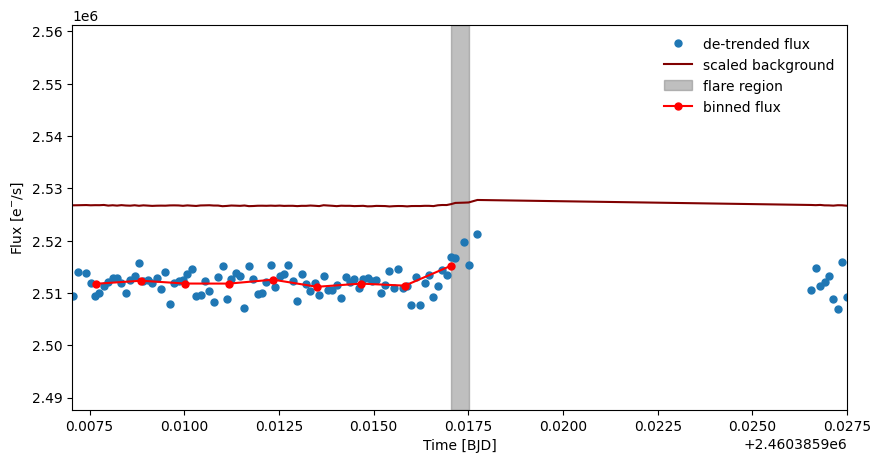

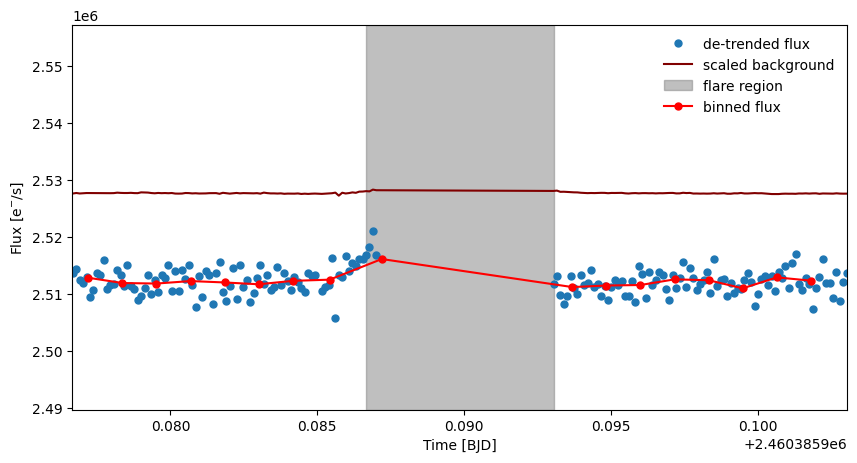

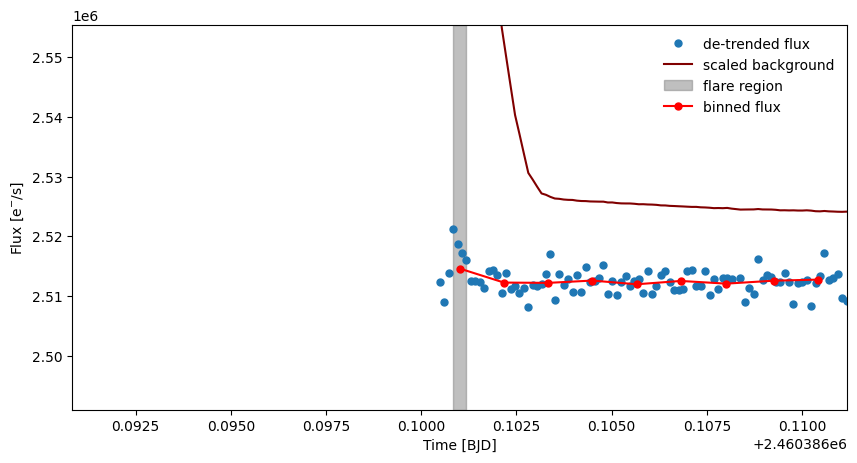

In [25]:
%matplotlib inline
# plot each flare from the flares list
for i, row in flares.iterrows():

    plt.figure(figsize=(10, 5))
      

    flare_m = (df.time > (row.tstart - 0.01)) & (df.time < (row.tstop + 0.01))

    tflare = df.time[flare_m].values
    fflare = df.flux[flare_m].values
    bgflare = df.bg[flare_m].values
    rangetflare = np.max(fflare) - np.min(fflare)

    bgflare = (bgflare - np.median(bgflare))*rangetflare/40 + np.median(df.flux) + rangetflare

    plt.plot(tflare, fflare, ".", markersize=10, label="de-trended flux")
    plt.plot(tflare, bgflare, color="maroon", label="scaled background")

    # now bin the data
    binsize = 10

    index = tflare.shape[0] % binsize

    # drop the last few data points
    t1 = tflare[:-index]
    f1 = fflare[:-index]

    binned_t = np.mean(t1.reshape(-1, binsize), axis=1)
    binned_f = np.mean(f1.reshape(-1, binsize), axis=1)


    # shade the region of the flare
    plt.axvspan(row.tstart, row.tstop, alpha=0.5, color="grey", label="flare region")
    
    plt.plot(binned_t, binned_f, ".-", markersize=10, color="red", label="binned flux")
    plt.xlabel(time_label)
    plt.ylabel(flux_label)
    plt.legend(frameon=False)
    plt.xlim(row.tstart - 0.01, row.tstop + 0.01)
    plt.ylim(np.median(fflare) - 10*np.std(fflare), np.median(fflare) + 20*np.std(fflare))

/tmp/ipykernel_57545/3535859710.py:4: ResourceWarning: unclosed file <_io.BufferedReader name='../data/hip67522/CHEOPS-products-20240319122713/Outdata/00000/residuals_im.fits'>
  hdulist = fits.open(IMG)


Residuals image file found for 20240319122713:
 ../data/hip67522/CHEOPS-products-20240319122713/Outdata/00000/residuals_im.fits

Image shape: (2775, 60, 60)
Light curve shape: (2775, 9)


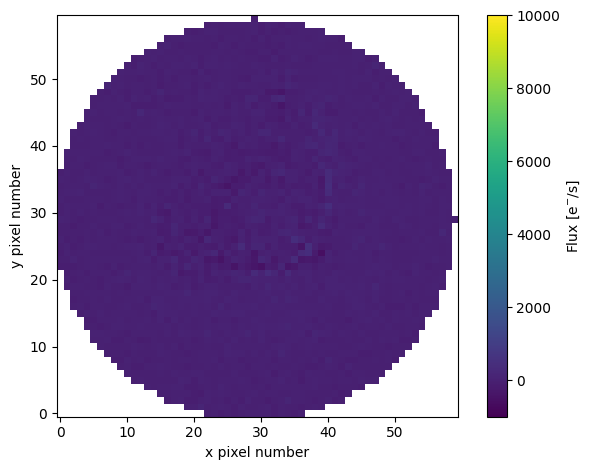

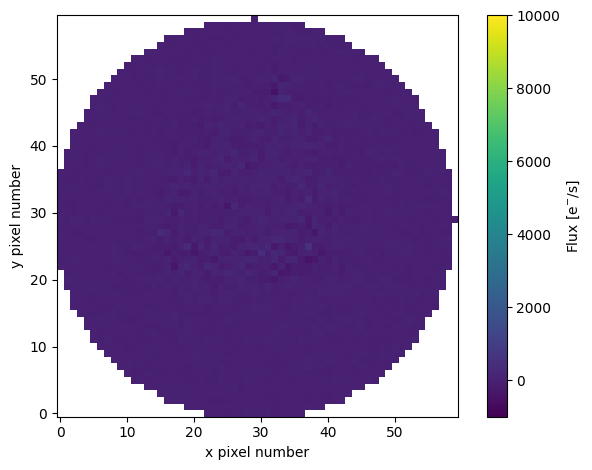

In [21]:
from astropy.io import fits    

IMG = f'../data/hip67522/CHEOPS-products-{file}/Outdata/00000/residuals_im.fits'
hdulist = fits.open(IMG)
print(f"Residuals image file found for {file}:\n {IMG}\n")

# read in mask
mask = np.loadtxt(mask_location, dtype=bool)

# get the image data
image_data = hdulist[0].data[mask]

print(f"Image shape: {image_data.shape}")
print(f"Light curve shape: {df.shape}") 


index = flares.iloc[-1].istart
index_end = flares.iloc[-1].istop
deltaindex = index_end - index

# sum over the first axis
image_data = image_data[index:index_end].sum(axis=0)

# show the image
plt.imshow(image_data, cmap="viridis", origin="lower", vmin=-1000, vmax=10000)
plt.colorbar(label=r"Flux [e$^{-}$/s]")

plt.xlabel("x pixel number")
plt.ylabel("y pixel number")

plt.tight_layout()

# make another image 20 indices later
index += 20
index_end += 20
image_data = hdulist[0].data[mask][index:index_end].sum(axis=0)

plt.figure()
plt.imshow(image_data, cmap="viridis", origin="lower", vmin=-1000, vmax=10000)
plt.colorbar(label=r"Flux [e$^{-}$/s]")
plt.xlabel("x pixel number")
plt.ylabel("y pixel number")

plt.tight_layout()

In [26]:
true_flares_index = [2]

# for each true flare put a 1 in the flare table
flares["true_flares"] = 0

# change the value of the true flare to 1
flares.loc[true_flares_index, "true_flares"] = 1

flares

,istart,istop,cstart,cstop,tstart,tstop,ed_rec,ed_rec_err,ampl_rec,dur,total_n_valid_data_points,true_flares
0,835,838,NaN,NaN,2.460386e+06,2.460386e+06,0.081046,0.017484,0.002931,0.000464,2775.0,0
1,1147,1151,NaN,NaN,2.460386e+06,2.460386e+06,0.991903,0.169722,0.003422,0.006382,2775.0,0
2,1663,1666,NaN,NaN,2.460386e+06,2.460386e+06,0.079809,0.013920,0.003498,0.000348,2775.0,1


In [27]:

# write flare data to file

# if ../results/{file} does not exist, create it
if not os.path.exists(f"../results/{file}"):
    os.makedirs(f"../results/{file}")

flares.to_csv(f"../results/{file}/flare_candidates.csv", index=False)